In [1]:
from __future__ import division

import numpy as np
import cv2
import sys

from matplotlib.pyplot import imshow

import math

In [2]:
recs = [(68, 11, 98, 29),
(68, 29, 86, 89),
(68, 110 , 86, 128),
(68, 164 , 98, 182),
(68, 182 , 86, 242),
(68, 263 , 86, 281),
(137 , 11, 155 , 29),
(137 , 50, 155, 128),
(125, 110, 137, 128),
(137, 164, 155, 182),
(137, 203, 155, 281),
(125, 263, 137, 281),
(191 , 11, 221 , 29),
(191 , 29, 209 , 89),
(191, 110, 209, 128),
(191, 164, 221, 182),
(191, 182, 209, 242),
(191, 263, 209, 281),
(260 , 11, 278 , 29),
(260 , 50, 278, 128),
(248, 110, 272, 128),
(260, 164, 278, 182),
(260, 203, 278, 281),
(248, 263, 260, 281)]
recs = list(map(lambda x: list(map(lambda y: y - 1, x)), recs))

recs = np.array(recs)

In [3]:
def build_inno_map(recs, M):
    '''
    Building the resized map of innopolis region of size 300x300 m.
    Input:
        recs - [(x1_1, y1_1, x2_1, y2_1), ..., (x1_n, y1_n, x2_n, y2_n)] array of building coordinates as tuples
        M - the size of the grid to construct
    Output:
        img - the array of shape (M, M) buildings are 0 and free area are 1
    '''
    img = np.ones((300, 300), np.uint8)
    for rect in recs:
        cv2.rectangle(img, (rect[0], 300 - rect[1]), (rect[2], 300 - rect[3]), (0,), -1)

    img = cv2.resize(img, (M, M), cv2.INTER_NEAREST)

    return img

In [4]:
def FindPoint(x, y):
    '''
    check whether the point corresponds to the point inside the building
    '''
    for rec in recs:
        x1, y1, x2, y2 = rec
        if (x > x1 and x < x2 and
                    y > y1 and y < y2):
            return True
    return False

In [5]:
def is_border(x, y):
    '''
    check whether the point corresponds to the border of the building
    '''
    for rec in recs:
        x1, y1, x2, y2 = rec
        if (((x > x1) and (x < x2)) and ((y1 == y) or (y2 == y))) \
                or (((y > y1) and (y < y2)) and ((x1 == x) or (x2 == x))):
            return True
        else:
            return False

In [6]:
def coef_in_range(lamda, k, h):
    return (abs(lamda) / k) <= (2 / h)

In [7]:
def converged(X, eps):
    '''
    convergence condition of the iteration method
    '''
    X = np.array(X)
    if X.shape[0] < 2:
        return False
    diff1 = (X[-1] - X[-2])
    conv = np.sum(np.abs(diff1)) <= eps
    return conv

In [31]:
def iteration(A, B, eps=1e-5, max_iter=100, tao=None):
    '''
    Fixed-point iteration method to solve Advection-diffusion equation
    '''
    M = int(math.sqrt(A.shape[0]))
    Z = np.diag((np.reciprocal(np.diag(A) + 1e-5)))
    if tao=='optim1':
        lambda_min = 0
        lambda_max = 7.995645745273593
        tao = 2 / (lambda_min + lambda_max)
    elif tao=='optim2':
        tao = 1/(4*0.5*M**2)
    if tao is not None:
        toa = tao
    else:
        tao = ((1/(4*0.5*(M**2))))*100
        tao = 0.04
    print("Tao: ", tao)
    X = [np.matmul(Z, B)]
    it = 0
    while not converged(X, eps):
        X_new = X[-1] - tao * (np.matmul(A, X[-1]) - B)
        X.append(X_new)
        if it == max_iter:
            return X[-1]
        it+=1
    return X[-1]

In [9]:
def build_matrix(inno_map, lamda1=1, lamda2=0, k=0.5, step_size=1):
    '''
    Building the matrix for advection diffusion equation for the innopolis map.
    A:
    Матрица A инициализируется 0. Далее следует проверка, лежит ли каждая из точек в пределах зданий, 
    если входит то оставляем строчку соответсвующую данной точке обнуленной. Иначе переходим к следующим проверкам.
    Узлы сетки интерполируются соседними при условии что они (соседи) не являются границами 
    и не лежат на зданиях, в противном случае, если соседи интерполиремых значений являются 
    границами или лежат на здании, то в строчке соответствующей интерполируюему значению эти 
    соседи обозначаются нулями.
    B:
    Создаем карту города на основе координат зданий. Описание карты в спецификации метода 'build_inno_map'. 
    Карта задает граничные условия для всей сетки, кроме границ u(x, 0), u(x, 1), u(0, y), u(1, y). 
    Границы u(x, 0), u(x, 1), u(0, y), u(1, y) обозначаются в следующем условии.
    
    '''
    M = inno_map.shape[0]
    print(f'M: {M}')
    u = np.zeros((M ** 2, M ** 2))
    b = np.zeros(M ** 2)
    coords = []
    for i, y in enumerate(np.arange(0, M, step_size)):
        for j, x in enumerate(np.arange(0, M, step_size)):
            coords.append((x, y))
            A = np.zeros((M, M), dtype=np.float32)
            if not FindPoint(y, x):
                A[i, j] = 4
                h = 1/M
                r1 = (lamda1 * h) / (2 * k)
                r2 = (lamda2 * h) / (2 * k)
                # we do not approximate by the border points
                if not FindPoint(x, y - step_size) and \
                        not is_border(x, y - step_size) and y > 0:
                    A[i, j - 1] = -1 * (1 + r2)
                if not FindPoint(x, y - step_size) and \
                        not is_border(x, y - step_size) and y < M - 1 and j!=M-1:
                    A[i, j + 1] = -1 * (1 - r2)
                if not FindPoint(x - step_size, y) and \
                        not is_border(x - step_size, y) and x > 0:
                    A[i - 1, j] = -1 * (1 + r1)
                if not FindPoint(x + step_size, y) and \
                        not is_border(x + step_size, y) and x < M - 1 and i!=M-1:
                    A[i + 1, j] = -1 * (1 - r1)

                u_line = A.ravel()  # M^2
                u[M * i + j, :] = u_line

                b[M * i + j] += inno_map[x, y]
                if x == 0:
                    b[M * i + j] += 1
                if (x == M - 1) or (y == 0) or (y == M - 1):
                    b[M * i + j] = 0
    return u, b, coords

In [10]:
f = open('input.txt', 'r')
f2 = open('output.txt', 'w')
f1 = f.readlines()
str1 = list(map(float, f1[0].split(' ')))

#### 1. Задаем параметры для построения матрицы A

In [14]:
eps = 1e-5
M = 100
lamda1 = 1
lamda2 = 0
k = 0.5

#### 2. Строим карту Иннополиса

In [15]:
inno_map = build_inno_map(recs, M)

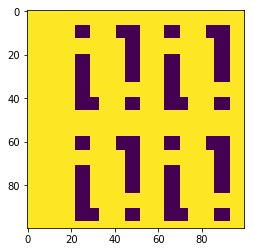

In [16]:
imshow(inno_map)

#### 3. Строим матрицу A и вектор B

In [17]:
A, B, coords = build_matrix(inno_map)

M: 100


In [18]:
print(A.shape)
print(B.shape)
print(A)
print("\n")
print(B)

(10000, 10000)
(10000,)
[[ 4. -1.  0. ...  0.  0.  0.]
 [ 0.  4. -1. ...  0.  0.  0.]
 [ 0.  0.  4. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]


[0. 0. 0. ... 0. 0. 0.]


#### 4. отправляем матрицу A и вектор B в метод итераций

tao подобранный

In [21]:
x = iteration(A, B, eps=1e-2, max_iter=1000)

Tao:  0.04


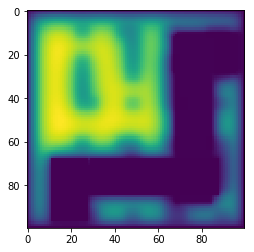

In [22]:
imshow(x.reshape((M, M)))

In [25]:
x = iteration(A, B, eps=1e-2, max_iter=1000, tao=0.005)

Tao:  0.005


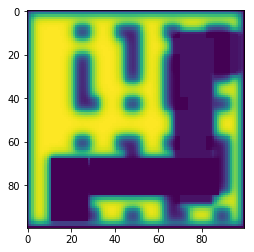

In [26]:
imshow(x.reshape((M, M)))

In [29]:
x = iteration(A, B, eps=1e-2, max_iter=1000, tao=0.001)

Tao:  0.001


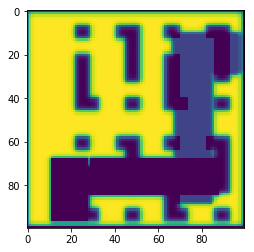

In [30]:
imshow(x.reshape((M, M)))

In [ ]:
оптимальный по формуле из домашнего задания

In [32]:
x = iteration(A, B, eps=1e-2, max_iter=1000, tao='optim2')

Tao:  5e-05


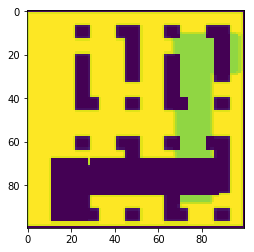

In [33]:
imshow(x.reshape((M, M)))

tao оптимальный вычесленный по вормуле 2/(L+l)

In [27]:
x = iteration(A, B, eps=1e-2, max_iter=1000, tao='optim1')

Tao:  0.25013614456121264


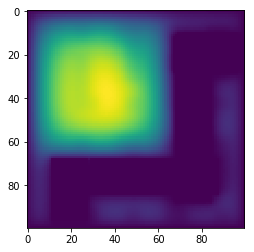

In [28]:
imshow(x.reshape((M, M)))

In [ ]:
f2.write(str(M)+" ")
it = 0
for c, u in zip(coords, x):
    f2.write(str(c[0]) + " " + str(c[1]) + " " + str(u)+" ")
    if ((it % 4*M) == 0) and (it > 0):
        f2.write("\n")
    it += 1